In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost.sklearn as xgb
import xgboost as x
import gensim
import seaborn as sns
import pickle

style.use('ggplot')
rcParams['font.size'] = 14
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'large'

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df_5class = df[df['Labels'] != 4].copy()

(9401, 3)

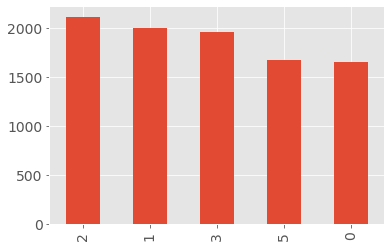

In [6]:
df_5class.Labels.value_counts().plot(kind='bar');
df_5class.shape
# Half-True - 2
# False - 1
# Mostly-True - 3
# True - 5
# Barely-True - 0
# Not-Known - 4

In [7]:
X = df_5class['Text']
y = df_5class['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
stopwords_ = set(stopwords.words('english'))

In [9]:
tfidf = TfidfVectorizer(stop_words=stopwords_)
words_train = tfidf.fit_transform(X_train).toarray()
words_test = tfidf.transform(X_test).toarray()
feats = tfidf.get_feature_names()

In [10]:
words_train.shape, words_test.shape

((7520, 10337), (1881, 10337))

In [11]:
pca = PCA()
pca.fit(words_train)

PCA()

In [12]:
filename = '../models/pca_model_5classes.sav'
pickle.dump(pca, open(filename, 'wb'))

In [13]:
words_tr_pca = pca.transform(words_train)
words_tst_pca = pca.transform(words_test)

In [30]:
def elbow_plot(pca, filename=None):
    total_variance = np.sum(pca.explained_variance_)
    cum_variance = np.cumsum(pca.explained_variance_)
    prop_var_expl = cum_variance/total_variance
    idx = np.argwhere(prop_var_expl > 0.9)[0][0] + 1

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
    ax.axhline(0.9, label=f'90% goal (at n_components={idx})', linestyle='--', color="black", linewidth=1)
    ax.set_ylabel('cumulative prop. of explained variance')
    ax.set_xlabel('number of principal components')
    ax.set_title('Elbow Plot')
    ax.legend()
    if filename != None:
        plt.savefig('../images/pca5c_cumulsum_elbow.png')
    return idx

3068

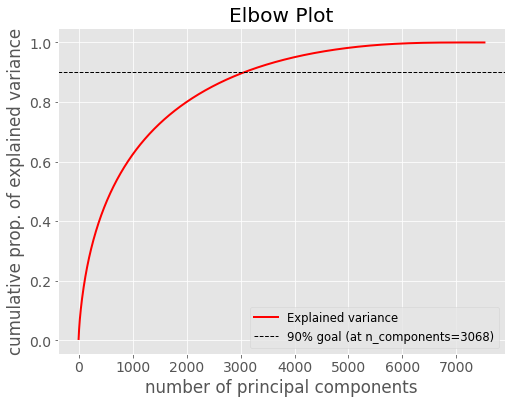

In [31]:
elbow_plot(pca)

In [15]:
np.argwhere(prop_var_expl > 0.9)[0][0]

3067

In [32]:
prop_var_expl[3262]

0.9000272792363343

In [70]:
words.shape

(10240, 12061)

In [21]:
comp = 3068
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(words_tr_pca[:,:comp], y_train)
y_pred = rf.predict(words_tst_pca[:,:comp])

In [61]:
filename = '../models/rf2_5classes.sav'
pickle.dump(rf, open(filename, 'wb'))

In [22]:
# print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(classification_report(y_train, rf.predict(words_tr_pca[:,:comp])))
rf.score(words_tr_pca[:,:comp], y_train)

              precision    recall  f1-score   support

           0       0.16      0.06      0.09       331
           1       0.23      0.30      0.26       399
           2       0.23      0.38      0.29       423
           3       0.25      0.25      0.25       393
           5       0.15      0.05      0.08       335

    accuracy                           0.22      1881
   macro avg       0.20      0.21      0.19      1881
weighted avg       0.21      0.22      0.20      1881

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1323
           1       1.00      1.00      1.00      1596
           2       1.00      1.00      1.00      1691
           3       1.00      1.00      1.00      1569
           5       1.00      1.00      1.00      1341

    accuracy                           1.00      7520
   macro avg       1.00      1.00      1.00      7520
weighted avg       1.00      1.00      1.00      7520



0.999468085106383

In [23]:
confusion_matrix(y_test, y_pred)

array([[ 21,  90, 143,  59,  18],
       [ 33, 120, 146,  78,  22],
       [ 28, 118, 162,  96,  19],
       [ 28,  96, 132, 100,  37],
       [ 25,  98, 127,  68,  17]])

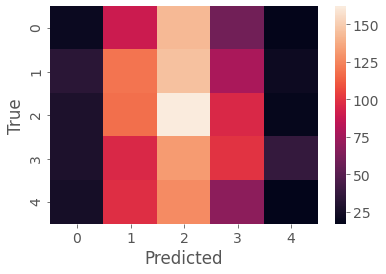

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.xlabel('Predicted')
plt.ylabel('True');

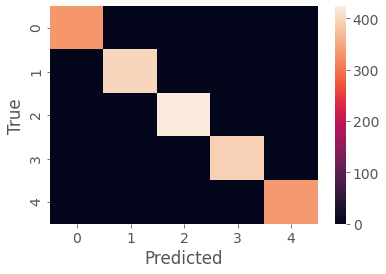

In [26]:
# if it were a perfect prediction

sns.heatmap(confusion_matrix(y_test, y_test))
plt.xlabel('Predicted')
plt.ylabel('True');

In [32]:
tfidf = TfidfVectorizer(stop_words=stopwords_, max_features=5000)
words_train = tfidf.fit_transform(X_train).toarray()
words_test = tfidf.transform(X_test).toarray()
feats = tfidf.get_feature_names()

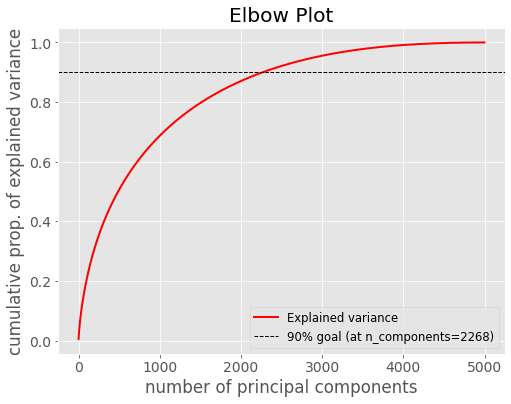

In [33]:
pca = PCA()
pca.fit(words_train)
comp = elbow_plot(pca)

In [34]:
words_tr_pca = pca.transform(words_train)
words_tst_pca = pca.transform(words_test)

In [57]:
print(comp)
rf = RandomForestClassifier(class_weight='balanced', max_depth=5,
                       n_estimators=120)
rf.fit(words_tr_pca[:,:comp], y_train)
y_pred = rf.predict(words_tst_pca[:,:comp])

2268


In [40]:
2268**0.5

47.62352359916263

In [50]:
params = {
            'n_estimators': [80,100,120],
            'max_features': [40,50,60],
            'max_depth': [5,10,15]
         }

rf_be = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'), 
                           params, 
                           random_state=0, 
                           scoring='f1_weighted',
                           n_jobs=-1,
                           return_train_score=True)

search = rf_be.fit(words_tr_pca[:,:comp], y_train)
search.best_params_

{'n_estimators': 120, 'max_features': 50, 'max_depth': 5}

In [52]:
search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=50,
                       n_estimators=120)

In [58]:
print(classification_report(y_train, rf.predict(words_tr_pca[:,:comp])))
print(classification_report(y_test, y_pred))

rf.score(words_tr_pca[:,:comp], y_train)

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1323
           1       0.70      0.71      0.70      1596
           2       0.77      0.61      0.68      1691
           3       0.62      0.73      0.67      1569
           5       0.79      0.73      0.76      1341

    accuracy                           0.71      7520
   macro avg       0.71      0.71      0.71      7520
weighted avg       0.71      0.71      0.71      7520

              precision    recall  f1-score   support

           0       0.20      0.24      0.22       331
           1       0.27      0.31      0.29       399
           2       0.25      0.17      0.20       423
           3       0.27      0.35      0.30       393
           5       0.22      0.15      0.18       335

    accuracy                           0.25      1881
   macro avg       0.24      0.24      0.24      1881
weighted avg       0.24      0.25      0.24      1881



0.7055851063829788

In [54]:
filename = '../models/pca_5c_maxfeats.sav'
pickle.dump(pca, open(filename, 'wb'))

In [59]:
filename = '../models/rf4.sav'
pickle.dump(rf, open(filename, 'wb'))

## GBoosting

In [66]:
params = {
#             'max_depth': (3, 5, 7),    # d-6
#             'reg_alpha': (0, 0.01),       # Lasso (L1) d-0
#             'reg_lambda': (1, 5, 10),   # Ridge (L2)   d-1
#             'colsample_bynode': (1, 0.75, 0.5),
#             'gamma': (0, 0.1, 0.3),   # d-0
#             'min_child_weight': (1, 3),   # d-1
             'subsample': (1, 0.8, 0.5),  # d-1 ... do 0.5 or something in the middle
#             'n_estimators': (500)
         }

In [81]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = x.DMatrix(X, label=y)
        cvresult = x.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='f1_weighted')
        
    #Predict training set:
    y_pred = alg.predict(X)
#     dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(classification_report(y, y_pred))
    
#     print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    


In [90]:
# gb = xgb.XGBClassifier(objective='multi:softmax', 
#                        n_estimators=500, 
#                        num_class=5, 
#                        learning_rate=0.1, 
#                        n_jobs=-1,
#                        seed=27)
# gb.fit(words_tr_pca[:,:comp], y_train)
y_pred = gb.predict(words_tst_pca[:,:comp])
# modelfit(gb, words_tr_pca[:,:comp], y_train)

In [92]:
print(classification_report(y_train, gb.predict(words_tr_pca[:,:comp])))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1323
           1       1.00      1.00      1.00      1596
           2       1.00      1.00      1.00      1691
           3       1.00      1.00      1.00      1569
           5       1.00      1.00      1.00      1341

    accuracy                           1.00      7520
   macro avg       1.00      1.00      1.00      7520
weighted avg       1.00      1.00      1.00      7520

              precision    recall  f1-score   support

           0       0.22      0.13      0.17       331
           1       0.26      0.30      0.28       399
           2       0.23      0.29      0.26       423
           3       0.27      0.34      0.30       393
           5       0.18      0.11      0.14       335

    accuracy                           0.24      1881
   macro avg       0.23      0.23      0.23      1881
weighted avg       0.23      0.24      0.23      1881



In [93]:
filename = '../models/gb1.sav'
pickle.dump(gb, open(filename, 'wb'))

In [95]:
N_ESTIMATORS = 500
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(gb.staged_predict(words_tr_pca[:,:comp])):
    train_score[i] = gb.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(gb.staged_predict(words_tst_pca[:,:comp])):
    test_score[i] = gb.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
_ = plt.ylim([0, 20])

AttributeError: 'XGBClassifier' object has no attribute 'staged_predict'

In [ ]:
gb = xgb.XGBClassifier(objective='multi:softmax', num_class=5, learning_rate=0.1)

search = GridSearchCV(gb, 
                           params, 
                           random_state=0, 
                           scoring='f1_weighted',
                           n_jobs=-1,
                           return_train_score=True)
search.fit(words_tr_pca[:,:comp], y_train)
search.best_params_

In [68]:
gb = xgb.XGBClassifier(objective='multi:softmax', num_class=5, learning_rate=0.1)

search = RandomizedSearchCV(gb, 
                           params, 
                           random_state=0, 
                           scoring='f1_weighted',
                           n_jobs=-1,
                           return_train_score=True)
search.fit(words_tr_pca[:,:comp], y_train)
search.best_params_

KeyboardInterrupt: 

In [64]:
df_5class['Text'].tolist()

['Says the Annies List political group supports third-trimester abortions on demand.',
 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
 'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
 'Health care reform legislation is likely to mandate free sex change surgeries.',
 'The economic turnaround started at the end of my term.',
 'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.',
 'Jim Dunnam has not lived in the district he represents for years now.',
 "I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate.",
 'However, it took $19.5 million in Oregon Lottery funds for the Port of Newport to eventually land the new NOAA Mari

In [65]:
df_5class['Text']

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10234    Under the ruling of the Supreme Court, any lob...
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
Name: Text, Length: 9401, dtype: object